In [65]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np
import cv2

In [66]:
IMAGE_FILE = '../data/examples/horses.jpg'

BLOCK_SIZE = 64
assert BLOCK_SIZE % 2 == 0

def BLOCK(x, y, dim = None, size = BLOCK_SIZE):
	if dim != None:
		return np.s_[x : x + size, y : y + size, dim]
	return np.s_[x : x + size, y : y + size]

(821, 1232, 3)


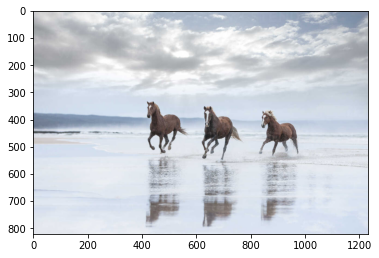

In [67]:
plt.rcParams['figure.figsize'] = [6, 6]

image = imread(IMAGE_FILE)

plt.figure()
plt.imshow(image)

print(image.shape)

In [68]:

def cut(value, multiple = BLOCK_SIZE):
	return int(multiple * np.floor(value / multiple))

print('original:', image.shape)

sliced = np.s_[0 : cut(image.shape[0]), 0 : cut(image.shape[1])]
image = image[sliced]

print('cut:', image.shape)

num_blocks = (image.shape[0] // BLOCK_SIZE) * (image.shape[1] // BLOCK_SIZE)
block_shape = (image.shape[0] // BLOCK_SIZE, image.shape[1] // BLOCK_SIZE)
print('num blocks:', num_blocks)

# plt.figure()
# plt.imshow(image)

original: (821, 1232, 3)
cut: (768, 1216, 3)
num blocks: 228


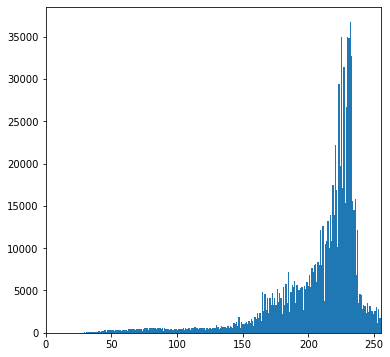

In [69]:
gray = image.mean(axis = 2)
vals = image.mean(axis = 2).flatten()

b, bins, patches = plt.hist(vals, 255)
plt.xlim([0, 255])
plt.show()

In [70]:
def inverse_std_score(pixels):
	return 1 / (np.std(pixels) + 1)

WORST_STD = (255 - 0) / 2

def linear_std_score(pixels):
	return 1.0 - np.std(pixels) / WORST_STD

# def sigmoid_std_score(pixels):
# 	return 1 / (1 + np.exp(-linear_std_score(pixels)))

print('inverse', inverse_std_score(image))
print('linear ', linear_std_score(image))
# print('sigmoid', sigmoid_std_score(image))

inverse 0.026991128099215108
linear  0.7172610902181189


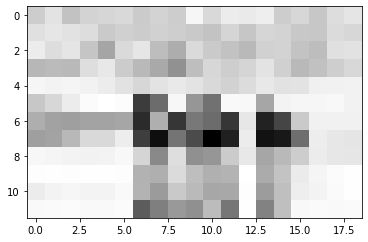

In [71]:

# scores = np.zeros((image.shape[0], image.shape[1]), dtype = np.uint8)

scores = np.zeros(block_shape, dtype = float)
slices = np.zeros(block_shape, dtype = object)

for i in np.r_[:image.shape[0] : BLOCK_SIZE]:
	for j in np.r_[:image.shape[1] : BLOCK_SIZE]:
		# scores[BLOCK(i, j)] = np.ones((BLOCK_SIZE, BLOCK_SIZE)) * linear_std_score(gray[BLOCK(i, j)]) * 255
		
		scores[i // BLOCK_SIZE, j // BLOCK_SIZE] = linear_std_score(gray[BLOCK(i, j)])
		slices[i // BLOCK_SIZE, j // BLOCK_SIZE] = BLOCK(i, j)

# scores[:, ::BLOCK_SIZE] = 0
# scores[::BLOCK_SIZE, :] = 0

# print(scores.flatten())

plt.figure()
plt.imshow(scores * 255, cmap = 'gray')


(array([7], dtype=int64), array([10], dtype=int64))
(slice(448, 512, None), slice(640, 704, None))


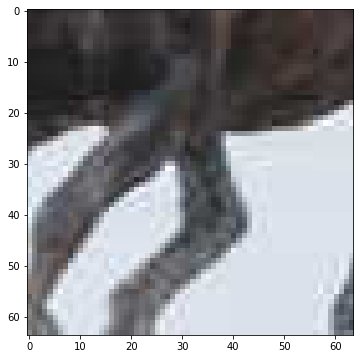

In [72]:
worst = np.where(scores == scores.min())
print(worst)

b = BLOCK(worst[0][0] * BLOCK_SIZE, worst[1][0] * BLOCK_SIZE)
print(b)

plt.figure()
plt.imshow(image[b], cmap = 'gray')

In [73]:

def insert_expansion(slices, index):

	sect = slices[index]

	r_start = sect[0].start
	r_stop = sect[0].stop

	c_start = sect[1].start

	dim = r_stop - r_start
	h_dim = int(dim / 2)

	TL = BLOCK(r_start, c_start, size = h_dim)
	TR = BLOCK(r_start, c_start + h_dim, size = h_dim)
	BL = BLOCK(r_start + h_dim, c_start, size = h_dim)
	BR = BLOCK(r_start + h_dim, c_start + h_dim, size = h_dim)

	splits = np.array([TL, TR, BL, BR], dtype = object)

	# new_slices = np.delete(slices, index)
	# print(slices.shape)
	# print(splits.shape)
	# new_slices = np.insert(slices, (index,), splits)

	a = np.asarray(slices).tolist()

	l = splits.tolist()

	a = np.array(a[:index] + l + a[index + 1:])
	# a[index] = splits.tolist()

	# print(splits.tolist())
	# print()

	return a
	
	# return new_slices


a = np.array([BLOCK(0, 0), BLOCK(0, 64), BLOCK(64, 0), BLOCK(64, 64)])

b = insert_expansion(a, 0)

print(b)
	


[[slice(0, 32, None) slice(0, 32, None)]
 [slice(0, 32, None) slice(32, 64, None)]
 [slice(32, 64, None) slice(0, 32, None)]
 [slice(32, 64, None) slice(32, 64, None)]
 [slice(0, 64, None) slice(64, 128, None)]
 [slice(64, 128, None) slice(0, 64, None)]
 [slice(64, 128, None) slice(64, 128, None)]]


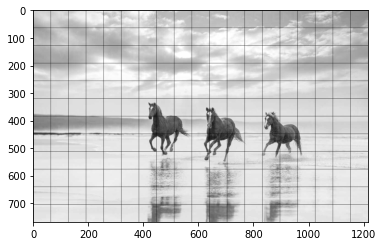

In [74]:

part = gray.copy()
part[:, ::BLOCK_SIZE] = 0
part[::BLOCK_SIZE, :] = 0

# i = 0
# for sect in slices:
# 	part[sect] = np.array()
# 	i += 10

plt.figure()
plt.imshow(part, cmap = 'gray')


In [75]:

x = """
### Naive Linear Quadtree Pseudocode ###

max_depth = log_2(max_block_size) = 6

O(N)

nodes = [slice_0, slice_1, ..., slice_n]

std_score_array = map(linear_std_score, nodes)

def split_threshold_nodes():

	splitters = np.where(std_scores_array > thresh)

	nodes = split(splitters) + nodes

	# Optimize to only new nodes added
	std_score_array = map(linear_std_score, nodes)

data = image_array

# Continue until partitioned becomes bigger than equal size or all blocks become reasonably compressable
while len(nodes) < len(data[8x8]) and max_std_score(nodes) > thresh:
	split_biggest_nodes()
"""
